In [1]:
import pandas, numpy, seaborn, scipy

In [2]:
import sklearn, sklearn.preprocessing
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'xtick.labelsize':20, 
                            'ytick.labelsize':20, 
                            'axes.labelsize':20, 
                            'figure.figsize':(12 * 0.8, 9 * 0.8)})

In [4]:
input_data_file = '/Users/adrian/gd15/research/vigur/data/targeted.2024.eva/EC_72_EVA_All_ION_MODES.xlsx'

In [5]:
basicdf = pandas.read_excel(input_data_file, sheet_name='BASIC_NEG', index_col='SAMPLE')

# batch & replicate 3

In [6]:
wdf = basicdf[basicdf['LCMS_BATCH_Biological_replicate'] == 3]

['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool']
['Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', 'Pool', '072-233', '072-247', '072-240']


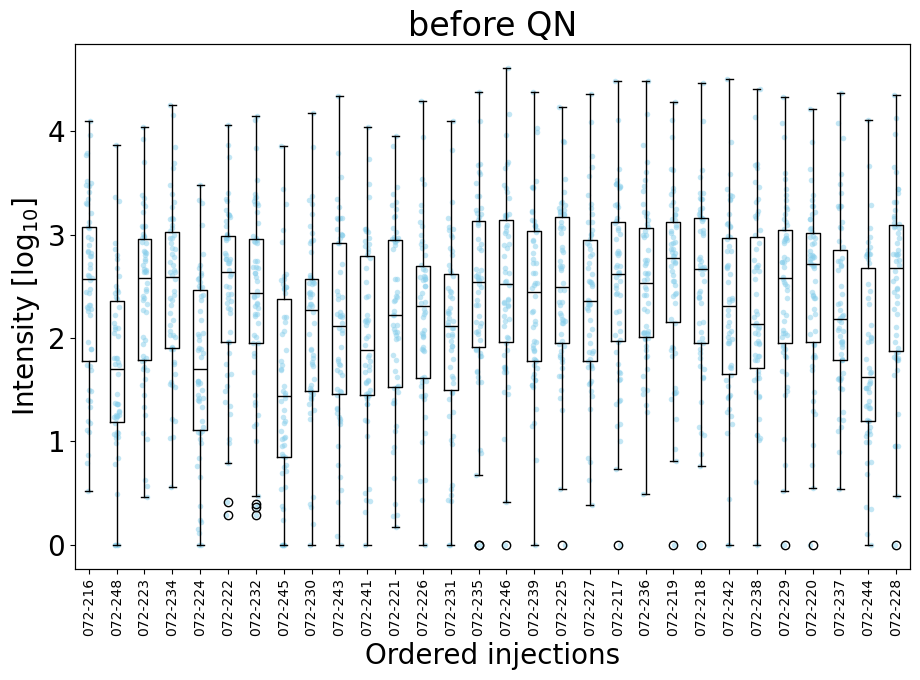

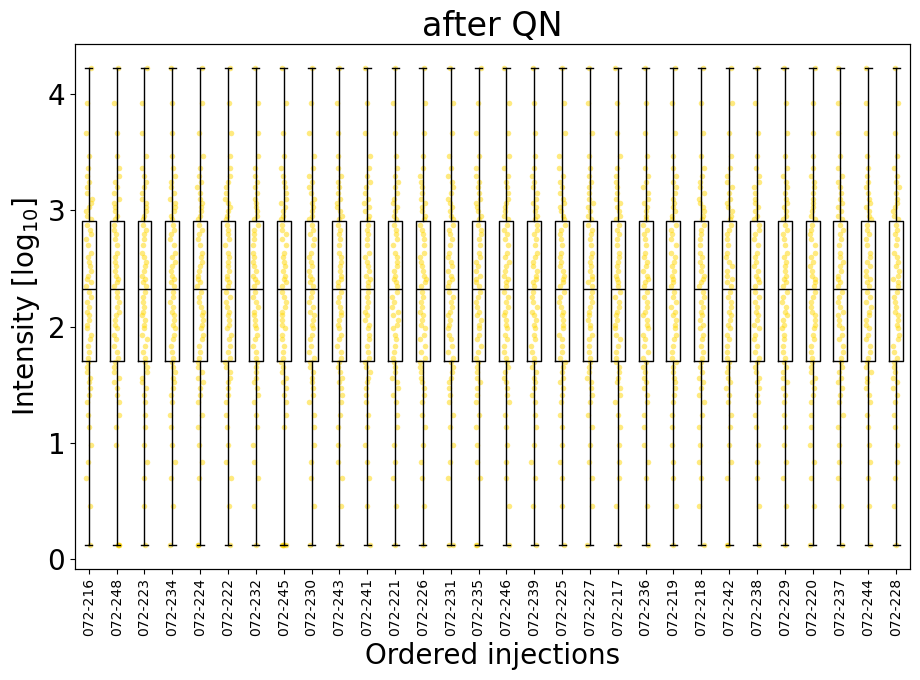

In [7]:
# transform
intensities = wdf.iloc[:, 7:]

rocks = []
for label in wdf.index:
    if isinstance(label, str) == False:
        rocks.append(label)
    else:
        if '072' not in label:
            rocks.append(label)  
print(rocks)
# 072-233, 072-247 & 072-240 failed
rocks.append('072-233')
rocks.append('072-247')
rocks.append('072-240')
print(rocks)
#
intensities.drop(rocks, axis=0, inplace=True)

intensities = intensities.transpose()
log10_intensities = numpy.log10(intensities + 1)

#plot
ax1 = log10_intensities.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(log10_intensities, color='skyblue', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('before QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_intensities.values, axis=0), 
                             index=log10_intensities.index, 
                             columns=log10_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot after
ax1 = df_qn.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_qn, color='gold', size=4, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Ordered injections')
ax1.set_ylabel('Intensity [log$_{10}$]')
matplotlib.pyplot.title('after QN')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

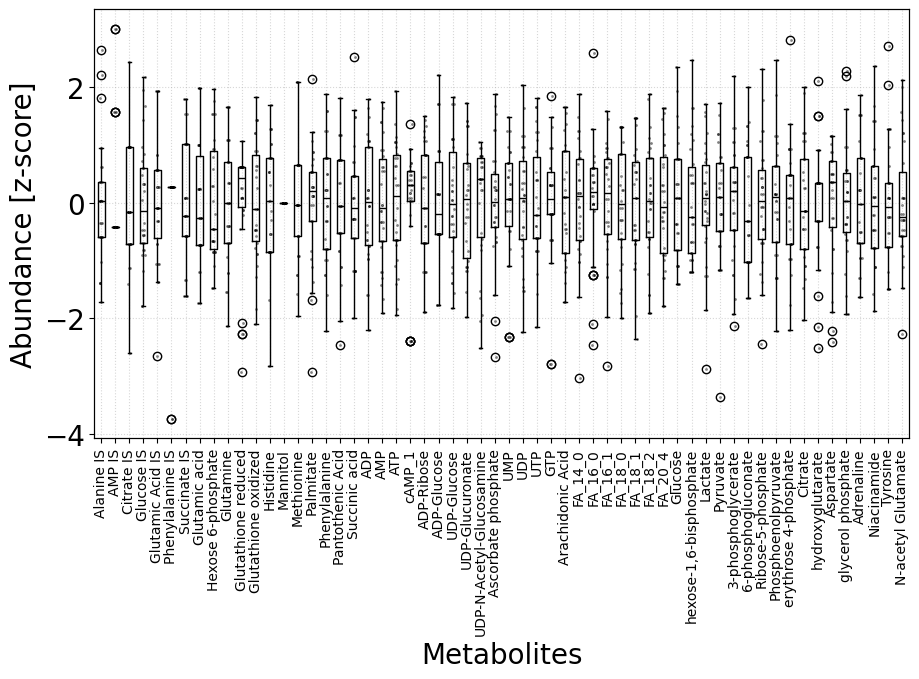

In [8]:
# transpose & scale
t_df_qn = df_qn.transpose()
std_scaler = sklearn.preprocessing.StandardScaler()
df_std = pandas.DataFrame(std_scaler.fit_transform(t_df_qn), columns=t_df_qn.columns, index=t_df_qn.index)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [9]:
print(log10_intensities.loc['AMP IS'].values)
print(df_qn.loc['AMP IS'].values)

[0.86723171 0.         0.45773055 0.55882852 0.         0.28824923
 0.3628593  0.         0.20411998 0.41346741 0.         0.17231097
 0.         0.         0.         0.         0.         0.
 0.38327665 0.         0.49387611 0.         0.         0.
 0.61044722 0.         0.         0.54245195 0.         0.        ]
[0.69613872 0.1235015  0.1235015  0.1235015  0.1235015  0.1235015
 0.45427082 0.1235015  0.45427082 0.69613872 0.1235015  0.1235015
 0.1235015  0.1235015  0.1235015  0.1235015  0.1235015  0.1235015
 0.1235015  0.1235015  0.1235015  0.1235015  0.1235015  0.1235015
 0.45427082 0.1235015  0.1235015  0.1235015  0.1235015  0.1235015 ]


In [10]:
print(log10_intensities.loc['Mannitol'].values)
print(df_qn.loc['Mannitol'].values)

[4.09813924 3.8674501  4.04000741 4.25027783 3.47888799 4.06349147
 4.14792771 3.85231527 4.17556275 4.33922203 4.03767915 3.95327406
 4.29064342 4.10158618 4.37401891 4.60913608 4.37946405 4.22972568
 4.36043654 4.48382429 4.48230945 4.28557968 4.47013414 4.50510725
 4.41168607 4.32990879 4.21664389 4.36568713 4.11050032 4.35411786]
[4.22215816 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816
 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816
 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816
 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816
 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816 4.22215816]


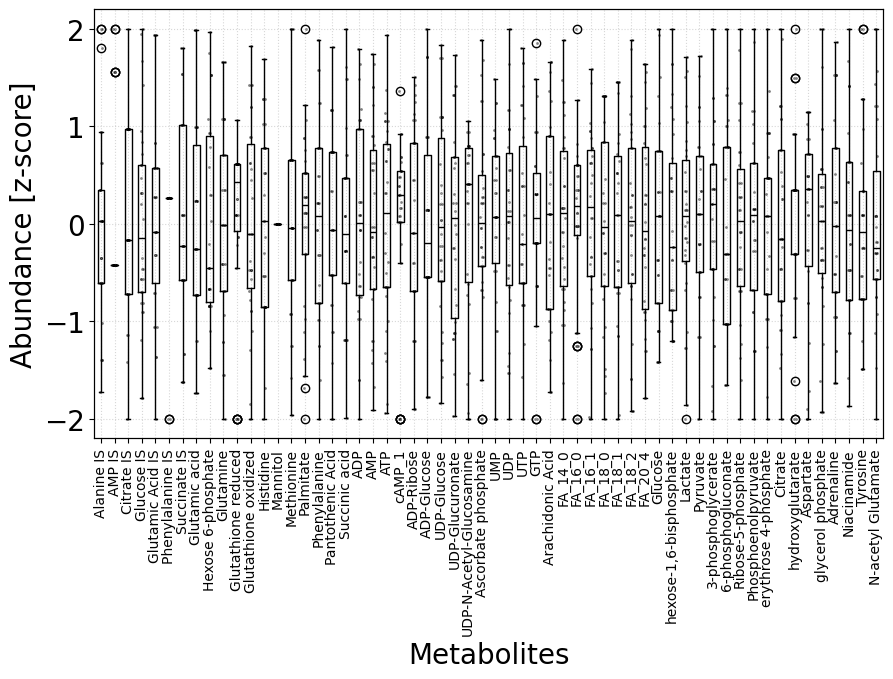

In [11]:
# clip
df_std.clip(-2, 2, inplace=True)

ax1 = df_std.boxplot(color='black', grid=False)
ax2 = ax1.twiny()
seaborn.stripplot(df_std, color='black', size=2, alpha=1/2, ax=ax2)
ax2.xaxis.set_visible(False)
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
ax1.tick_params(axis='x', labelrotation=90, labelsize=10)
ax1.set_xlabel('Metabolites')
ax1.set_ylabel('Abundance [z-score]')
ax1.grid(True, ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

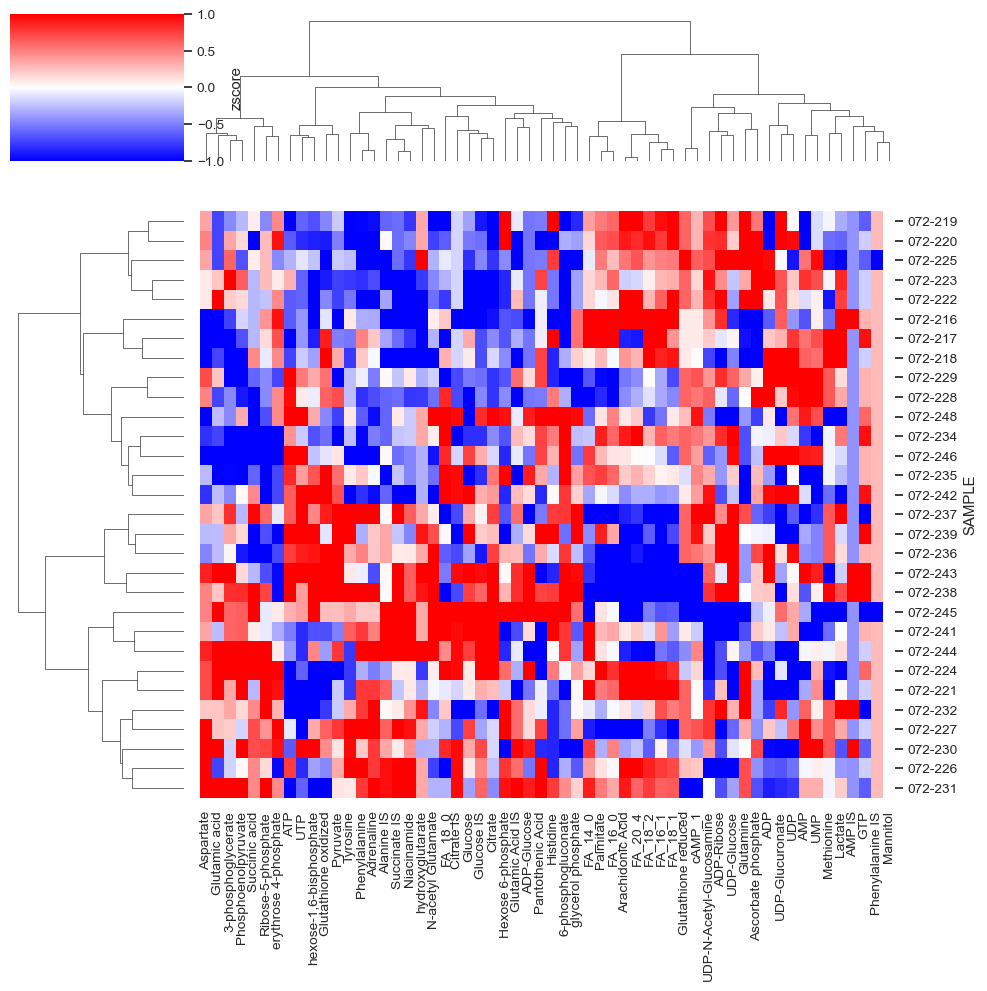

In [12]:
# visualize pattern
linkage_method = 'ward'
distance_metric = 'euclidean'

seaborn.set(font_scale=0.9)
seaborn.clustermap(df_std, 
                   cmap='bwr', col_cluster=True, vmin=-1, vmax=1, 
                   method=linkage_method, metric=distance_metric, 
                   yticklabels=1, xticklabels=1,
                   cbar_kws={'label':'zscore'})
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

seaborn.reset_orig()

In [13]:
print(df_std['Alanine IS'].mean())
print(df_std['Alanine IS'].std())

-0.027963673519330927
0.9500866291522448


Glutamine
Glutathione oxidized
Methionine
Palmitate
AMP
UMP
UTP
Arachidonic Acid
FA_16_1
FA_18_1
FA_18_2
FA_20_4
hexose-1,6-bisphosphate
glycerol phosphate
Tyrosine
We found significant metabolites: 6
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False]), array([9.39053706e-01, 7.09223773e-01, 1.00000000e+00, 8.92760213e-01,
       5.53556063e-01, 1.00000000e+00, 7.09223773e-01, 8.94700259e-01,
       1.82298110e-01, 5.57956303e-02, 7.09223773e-01, 9.20151477e-02,
       1.00000000e+00, 1.00000000e+00, 9.20151477e-02, 3.85644529e-02,
       8.66498876e-01, 7.43202174e-01, 9.55491333e-01, 2.

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531

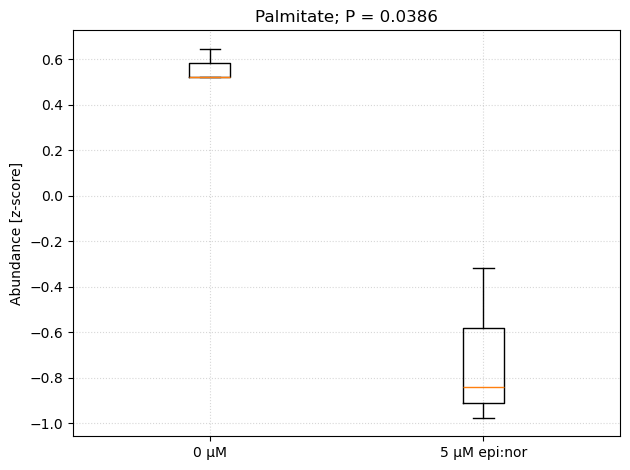

AMP 0.03230701965580902


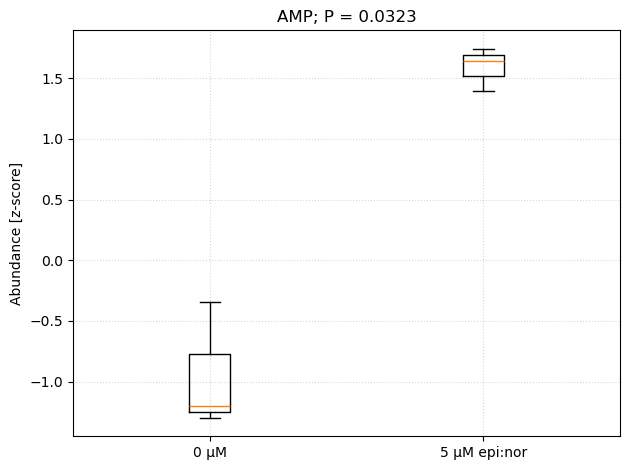

UMP 0.03856445289854026


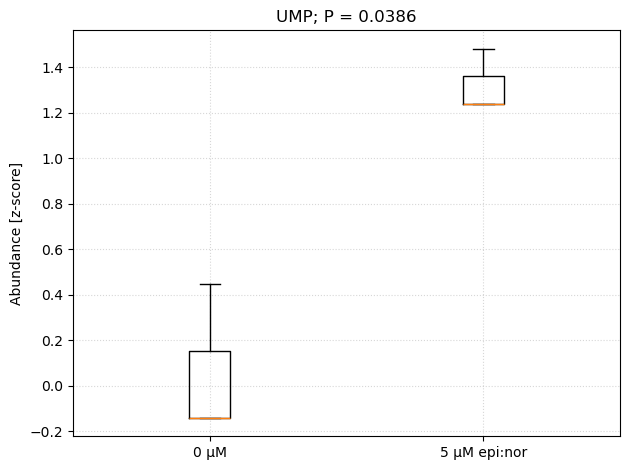

Arachidonic Acid 0.03230701965580902


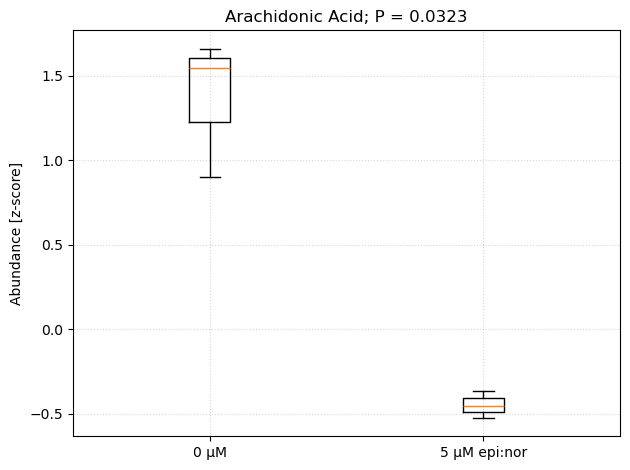

FA_18_1 0.0008909883374282306


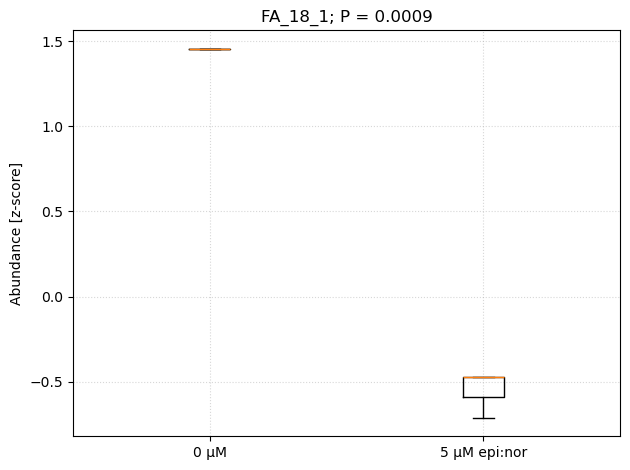

FA_20_4 0.03856445289854026


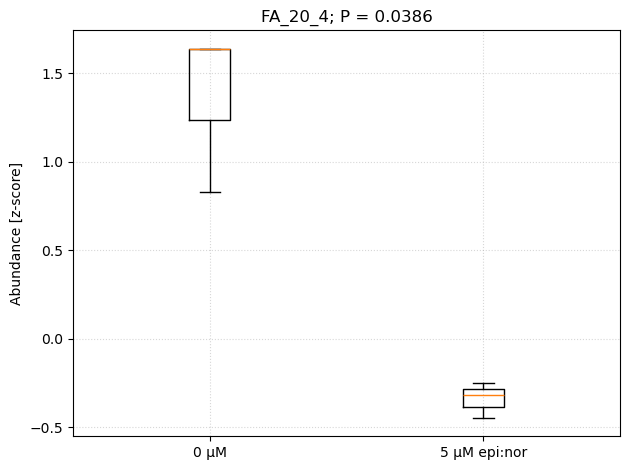

Glucose IS
Succinate IS
Glutamic acid
Glutathione reduced
Succinic acid
Glucose
3-phosphoglycerate
Phosphoenolpyruvate
Aspartate
Niacinamide
N-acetyl Glutamate
We found significant metabolites: 0
(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False]), array([0.28419529, 0.62527015, 0.28419529, 0.0646259 , 0.4561999 ,
       0.62527015, 0.0646259 , 0.07258633, 0.86614474, 0.98612468,
       0.20821221, 0.81510581, 0.98612468, 1.        , 0.28419529,
       0.78087324, 0.63819383, 0.55300842, 0.23772226, 0.91708408,
       0.31065711, 0.98612468, 0.31065711, 0.31065711, 0.86614474,
       0.51

/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/adrian/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [14]:
# test
timepoints = [4, 24]
timepoints = [4, 24]
control_label = '0µM'
sample_label = '5 µM epi:nor'
metabolites = df_std.columns

for timepoint in timepoints:
    #print('Timepoint {}'.format(timepoint))
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == control_label)
    controls = wdf[rules].index.to_list()
    rules = (wdf['TIME'] == timepoint) & (wdf['TREATMENT'] == sample_label)
    samples = wdf[rules].index.to_list()

    uncorrected = []
    for metabolite in metabolites:
        #print('\t', metabolite)
        existing = [control for control in controls if control in df_std.index]
        x = df_std.loc[existing, metabolite]
        existing = [sample for sample in samples if sample in df_std.index]
        y = df_std.loc[samples, metabolite]

        (statistic, pvalue) = scipy.stats.ttest_ind(x, y)
        if numpy.isnan(pvalue) == True:
            pvalue = 1
        uncorrected.append(pvalue)
        if pvalue < 0.05:
            print(metabolite)
            #print('\t\t', x.values, y.values, pvalue)
    results = statsmodels.stats.multitest.multipletests(uncorrected, method='fdr_bh')
    print('We found significant metabolites:', sum(results[0]))
    print(results)

    # plot significant
    for i in range(len(metabolites)):
        if results[0][i] == True:
            print(metabolites[i], results[1][i])
            metabolite = metabolites[i]
            a = df_std.loc[controls, metabolite]
            b = df_std.loc[samples, metabolite]
            matplotlib.pyplot.boxplot([a, b])
            matplotlib.pyplot.title('{}; P = {:.4f}'.format(metabolite, results[1][i]))
            matplotlib.pyplot.xticks([1, 2], ['0 µM', '5 µM epi:nor'])
            matplotlib.pyplot.ylabel('Abundance [z-score]')
            matplotlib.pyplot.grid(ls=':', alpha=0.5)
            matplotlib.pyplot.tight_layout()
            matplotlib.pyplot.show()